In [13]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

data = pd.read_csv("../Data/Processed/model_data.csv")

X = data.drop(columns=['Unjustified_Stop', 'Unjustified_Frisk', 'Unjustified_Search'])
y_stop = data['Unjustified_Stop']
y_frisk = data['Unjustified_Frisk']
y_search = data['Unjustified_Search']

X_train, X_test, y_stop_train, y_stop_test, y_frisk_train, y_frisk_test, y_search_train, y_search_test = train_test_split(
    X, y_stop, y_frisk, y_search, test_size=0.3, random_state=2024)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Logistic Regression with Lasso Regularization
def build_lasso_logistic(X_train, X_test, y_train, y_test, target_name):
    
    model = LogisticRegression(penalty='l1', solver='liblinear', random_state=2024, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    
    print(f"\nLasso Logistic Regression Results for {target_name}:")
    print(f"Log Loss: {log_loss(y_test, y_pred_proba): .3f}")
    print(f"Accuracy: {accuracy_score(y_test, model.predict(X_test)): .3f}")
    return model

lr_stop = build_lasso_logistic(X_train_scaled, X_test_scaled, y_stop_train, y_stop_test, "Unjustified Stop")
lr_frisk = build_lasso_logistic(X_train_scaled, X_test_scaled, y_frisk_train, y_frisk_test, "Unjustified Frisk")
lr_search = build_lasso_logistic(X_train_scaled, X_test_scaled, y_search_train, y_search_test, "Unjustified Search")


Lasso Logistic Regression Results for Unjustified Stop:
Log Loss:  0.622
Accuracy:  0.661

Lasso Logistic Regression Results for Unjustified Frisk:
Log Loss:  0.562
Accuracy:  0.710

Lasso Logistic Regression Results for Unjustified Search:
Log Loss:  0.402
Accuracy:  0.857


In [15]:
def select_features_for_gb(X_train, X_test, y_train, num_features):
    """
    Performs Recursive Feature Elimination (RFE) for Gradient Boosting.
    """
    model = GradientBoostingClassifier(random_state=2024)
    selector = RFE(model, n_features_to_select=num_features)
    selector.fit(X_train, y_train)
    
    selected_features = X.columns[selector.support_]
    print(f"\nSelected features for Gradient Boosting:\n{'=' * 40}")
    print('\n'.join(selected_features))
    print(f"{'=' * 40}\n")
    
    # Return transformed data with selected features
    return X_train[:, selector.support_], X_test[:, selector.support_], selected_features

# Selected features for the unjustified stop gradient boosting model
X_train_gb_stop, X_test_gb_stop, selected_features_stop = select_features_for_gb(
    X_train_scaled, X_test_scaled, y_stop_train, num_features=20)


Selected features for Gradient Boosting:
BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG
SUSPECT_REPORTED_AGE
Median_Income
Perc_Black
Day_of_Month
Hour_sin
Hour_cos
Day_of_Week_sin
Month_sin
Month_cos
STOP_WAS_INITIATED_Based on Self Initiated
DEMEANOR_OF_PERSON_STOPPED_CALM AND COOPERATIVE
DEMEANOR_OF_PERSON_STOPPED_COOPERATIVE
DEMEANOR_OF_PERSON_STOPPED_NERVOUS
DEMEANOR_OF_PERSON_STOPPED_SCARED
DEMEANOR_OF_PERSON_STOPPED_UNDERSTANDING
DEMEANOR_OF_PERSON_STOPPED_UPSET
SUSPECT_RACE_DESCRIPTION_WHITE
SUSPECT_BODY_BUILD_TYPE_THN
Borough_Manhattan



In [16]:
# Selected features for the unjustified frisk gradient boosting model
X_train_gb_frisk, X_test_gb_frisk, selected_features_frisk = select_features_for_gb(
    X_train_scaled, X_test_scaled, y_frisk_train, num_features=20)


Selected features for Gradient Boosting:
BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG
SUSPECT_REPORTED_AGE
Median_Income
Perc_Black
Day_of_Month
Hour_sin
Hour_cos
Day_of_Week_sin
Day_of_Week_cos
Month_sin
Month_cos
STOP_WAS_INITIATED_Based on Radio Run
STOP_WAS_INITIATED_Based on Self Initiated
ISSUING_OFFICER_RANK_DTS
DEMEANOR_OF_PERSON_STOPPED_NERVOUS
DEMEANOR_OF_PERSON_STOPPED_NORMAL
DEMEANOR_OF_PERSON_STOPPED_UNDERSTANDING
SUSPECT_SEX_MALE
SUSPECT_RACE_DESCRIPTION_WHITE
Borough_Manhattan



In [17]:
# Selected features for the unjustified search gradient boosting model
X_train_gb_search, X_test_gb_search, selected_features_search = select_features_for_gb(
    X_train_scaled, X_test_scaled, y_search_train, num_features=20)


Selected features for Gradient Boosting:
BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG
SUSPECT_REPORTED_AGE
Median_Income
Perc_Black
Day_of_Month
Hour_sin
Hour_cos
Day_of_Week_sin
Month_sin
Month_cos
STOP_WAS_INITIATED_Based on Radio Run
STOP_WAS_INITIATED_Based on Self Initiated
DEMEANOR_OF_PERSON_STOPPED_APPARENTLY NORMAL
DEMEANOR_OF_PERSON_STOPPED_CALM AND COOPERATIVE
DEMEANOR_OF_PERSON_STOPPED_COMBATIVE
SUSPECT_RACE_DESCRIPTION_BLACK
SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC
SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC
Borough_Brooklyn
Borough_Staten Island



In [18]:
# Function for the gradient boosting model (with hyperparameters tuning)
def build_gradient_boosting_with_tuning(X_train, X_test, y_train, y_test, target_name):
    
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
    
    grid_search = GridSearchCV(GradientBoostingClassifier(random_state=2024), param_grid, cv=3, scoring='neg_log_loss', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)
    
    print(f"\nGradient Boosting with Hyperparameter Tuning Results for {target_name}:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Log Loss: {log_loss(y_test, y_pred_proba): .3f}")
    print(f"Accuracy: {accuracy_score(y_test, best_model.predict(X_test)): .3f}")
    return best_model

In [19]:
gb_stop = build_gradient_boosting_with_tuning(X_train_gb_stop, X_test_gb_stop, y_stop_train, y_stop_test, "Unjustified Stop")
gb_frisk = build_gradient_boosting_with_tuning(X_train_gb_frisk, X_test_gb_frisk, y_frisk_train, y_frisk_test, "Unjustified Frisk")
gb_search = build_gradient_boosting_with_tuning(X_train_gb_search, X_test_gb_search, y_search_train, y_search_test, "Unjustified Search")


Gradient Boosting with Hyperparameter Tuning Results for Unjustified Stop:
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Log Loss:  0.600
Accuracy:  0.670

Gradient Boosting with Hyperparameter Tuning Results for Unjustified Frisk:
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Log Loss:  0.526
Accuracy:  0.733

Gradient Boosting with Hyperparameter Tuning Results for Unjustified Search:
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
Log Loss:  0.396
Accuracy:  0.858


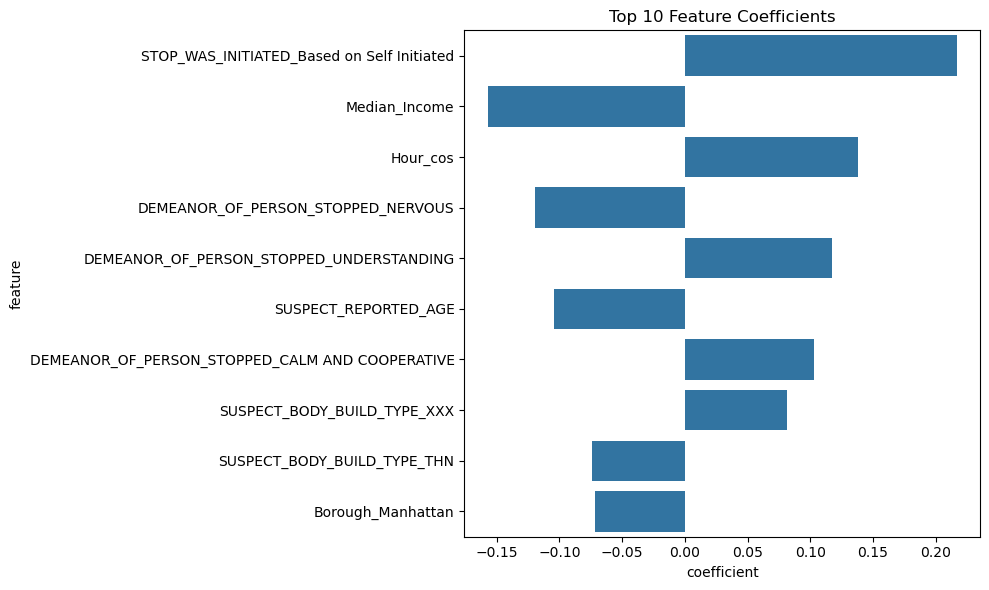

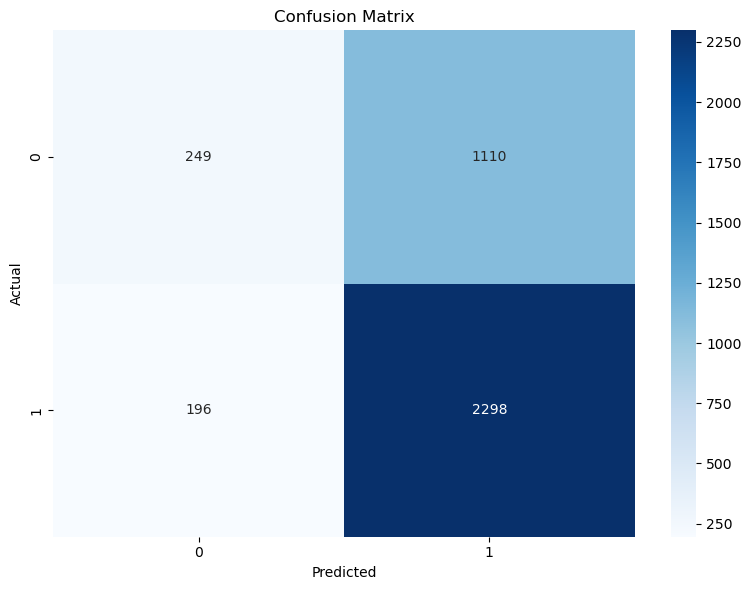

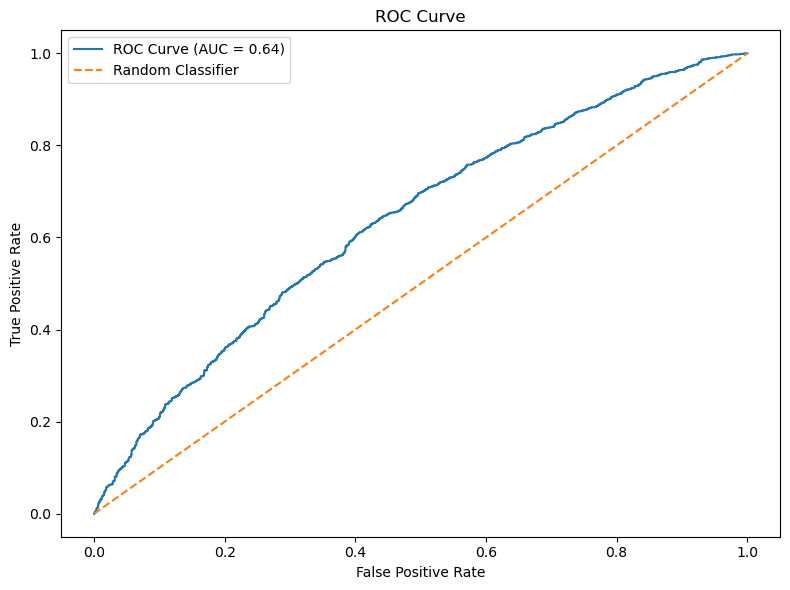

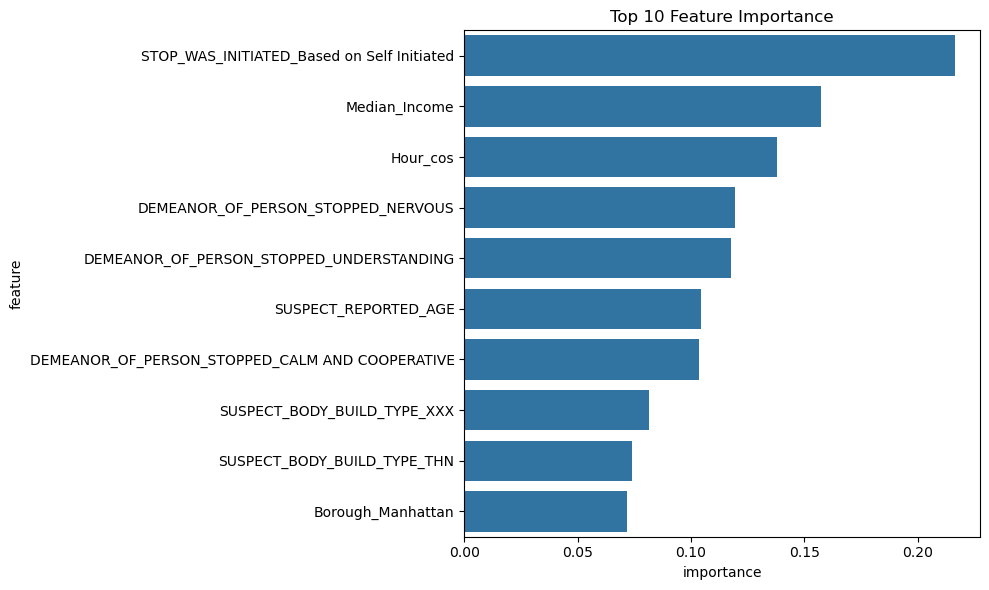

In [24]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Load and prepare data
data = pd.read_csv("model_data.csv")
X = data.drop(columns=['Unjustified_Stop', 'Unjustified_Frisk', 'Unjustified_Search'])
y_stop = data['Unjustified_Stop']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_stop, test_size=0.3, random_state=2024)

# Scale the features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Create and fit the model
model_lr = LogisticRegression(penalty='l1', solver='liblinear', random_state=2024)
model_lr.fit(scaled_X_train, y_train)

# Now create visualizations
plt.figure(figsize=(10, 6))
coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': model_lr.coef_[0]})
coef_df = coef_df.sort_values('coefficient', key=abs, ascending=False)
sns.barplot(x='coefficient', y='feature', data=coef_df.head(10))
plt.title('Top 10 Feature Coefficients')
plt.tight_layout()
plt.savefig('feature_coefficients.png')

# Confusion matrix
plt.figure(figsize=(8, 6))
y_pred = model_lr.predict(scaled_X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# ROC curve
y_pred_proba = model_lr.predict_proba(scaled_X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.savefig('roc_curve.png')

# Feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': abs(model_lr.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')

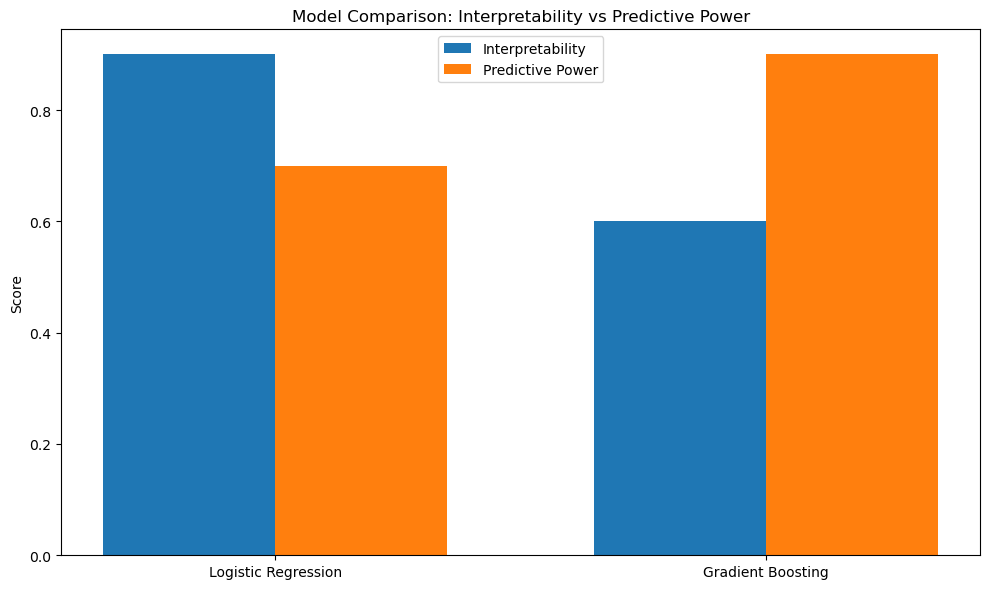

In [44]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Gradient Boosting']
interpretability = [0.9, 0.6]
predictive_power = [0.7, 0.9]

x = range(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, interpretability, width, label='Interpretability')
ax.bar([i + width for i in x], predictive_power, width, label='Predictive Power')

ax.set_ylabel('Score')
ax.set_title('Model Comparison: Interpretability vs Predictive Power')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

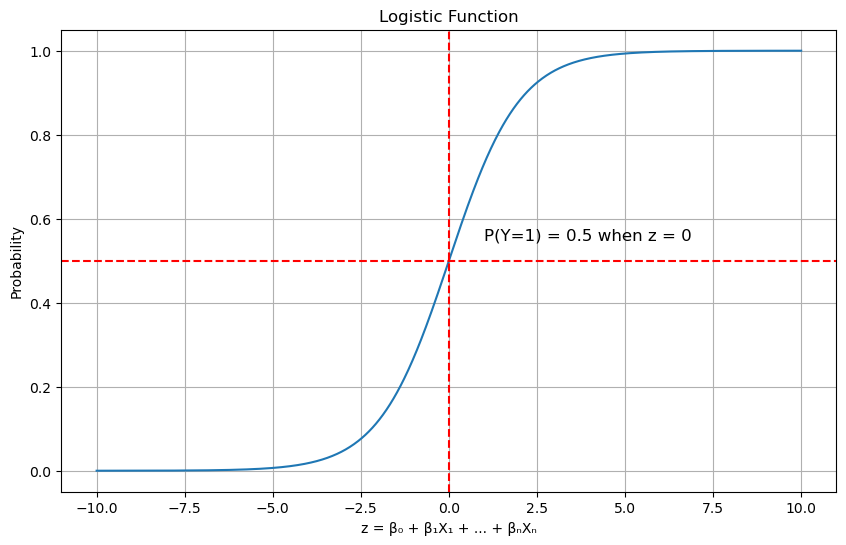

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def logistic(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-10, 10, 1000)
y = logistic(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Logistic Function')
plt.xlabel('z = β₀ + β₁X₁ + ... + βₙXₙ')
plt.ylabel('Probability')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.text(1, 0.55, 'P(Y=1) = 0.5 when z = 0', fontsize=12)
plt.grid(True)
plt.show()

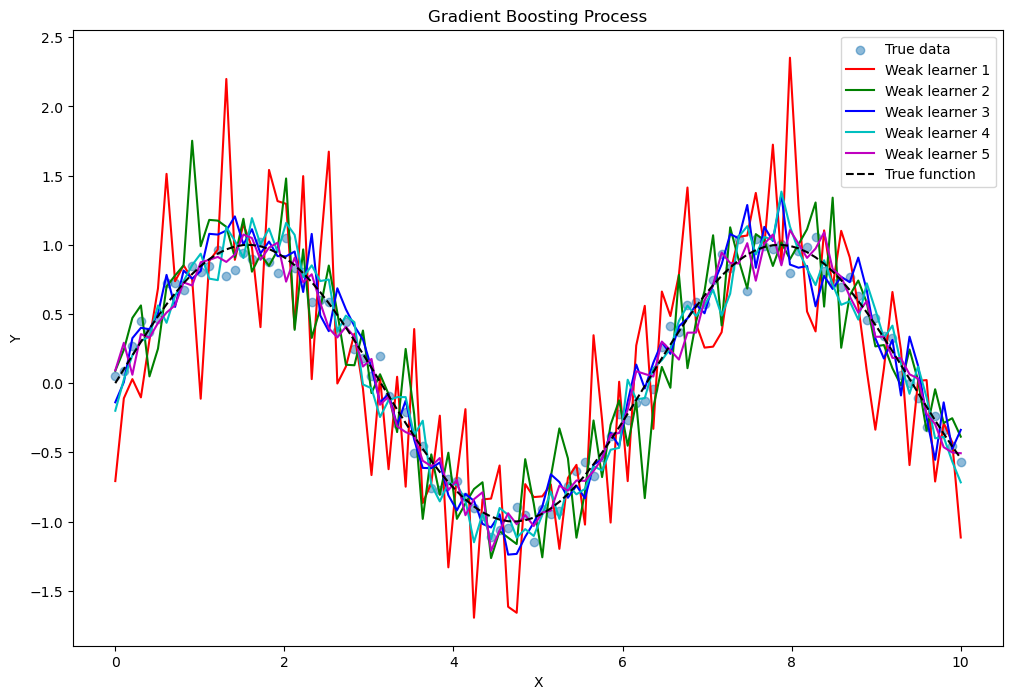

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_boosting_process():
    np.random.seed(42)
    x = np.linspace(0, 10, 100)
    y_true = np.sin(x) + np.random.normal(0, 0.1, 100)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(x, y_true, alpha=0.5, label='True data')
    
    colors = ['r', 'g', 'b', 'c', 'm']
    for i in range(5):
        y_pred = np.sin(x) + np.random.normal(0, 0.5 / (i+1), 100)
        plt.plot(x, y_pred, color=colors[i], label=f'Weak learner {i+1}')
    
    plt.plot(x, np.sin(x), 'k--', label='True function')
    plt.title('Gradient Boosting Process')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

plot_boosting_process()

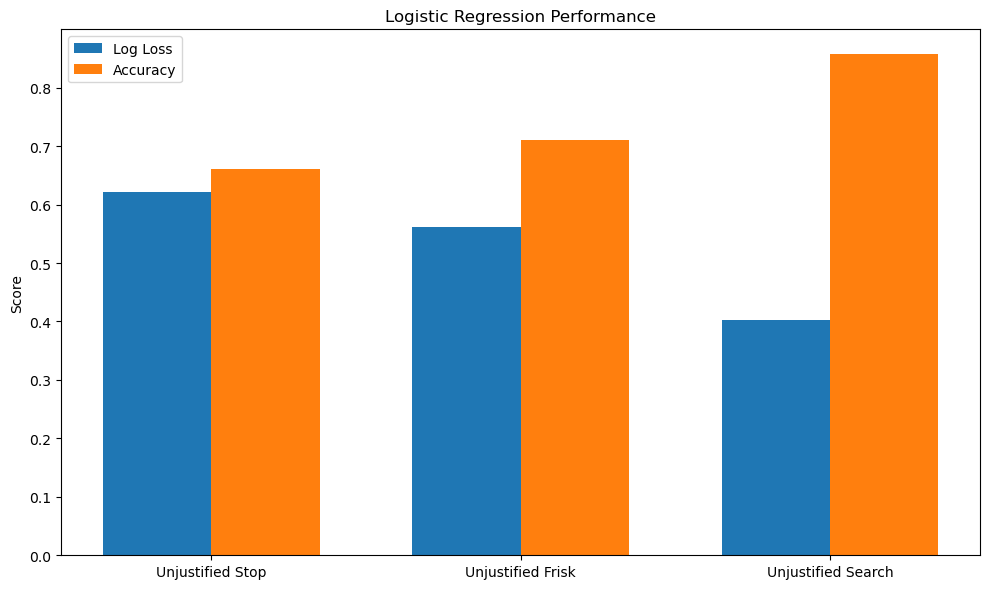

In [47]:
import matplotlib.pyplot as plt

models = ['Unjustified Stop', 'Unjustified Frisk', 'Unjustified Search']
log_loss = [0.622, 0.562, 0.402]
accuracy = [0.661, 0.710, 0.857]

x = range(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, log_loss, width, label='Log Loss')
ax.bar([i + width for i in x], accuracy, width, label='Accuracy')

ax.set_ylabel('Score')
ax.set_title('Logistic Regression Performance')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

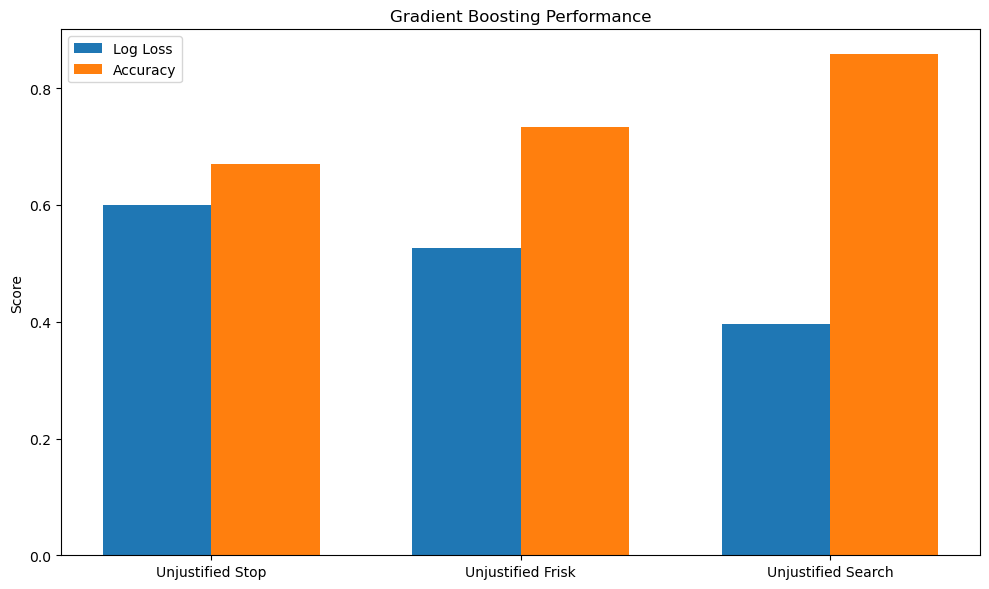

In [48]:
models = ['Unjustified Stop', 'Unjustified Frisk', 'Unjustified Search']
log_loss = [0.600, 0.526, 0.396]
accuracy = [0.670, 0.733, 0.858]

x = range(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, log_loss, width, label='Log Loss')
ax.bar([i + width for i in x], accuracy, width, label='Accuracy')

ax.set_ylabel('Score')
ax.set_title('Gradient Boosting Performance')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

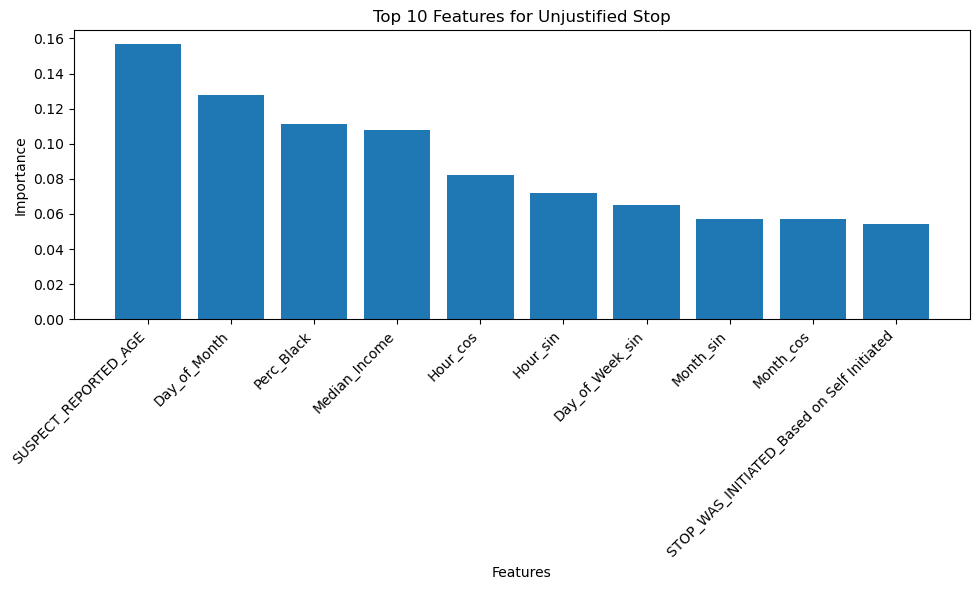

In [49]:
import pandas as pd

feature_importance = pd.DataFrame({
    'feature': selected_features_stop,
    'importance': gb_stop.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Features for Unjustified Stop')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

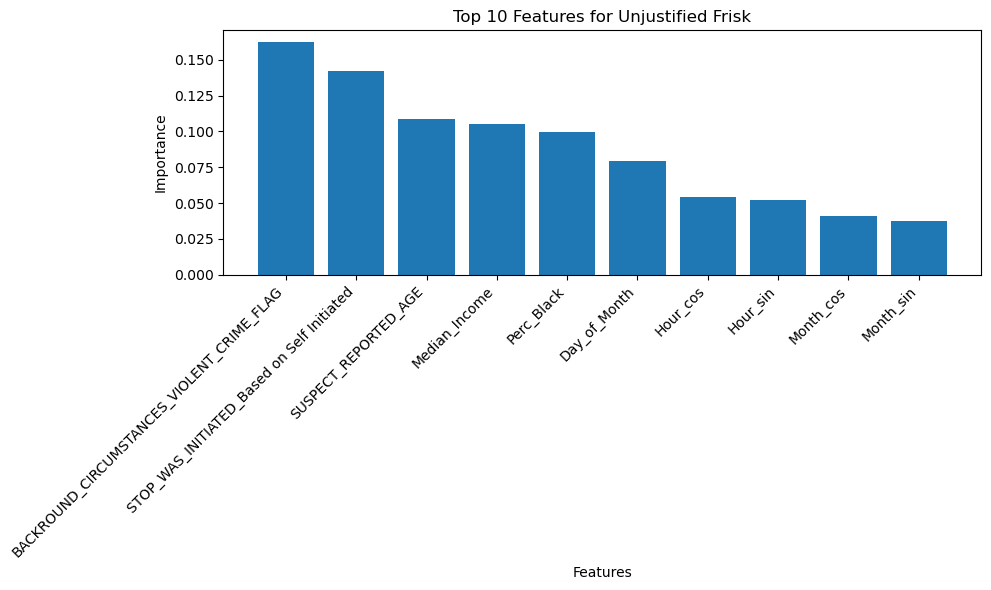

In [50]:
feature_importance = pd.DataFrame({
    'feature': selected_features_frisk,
    'importance': gb_frisk.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Features for Unjustified Frisk')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

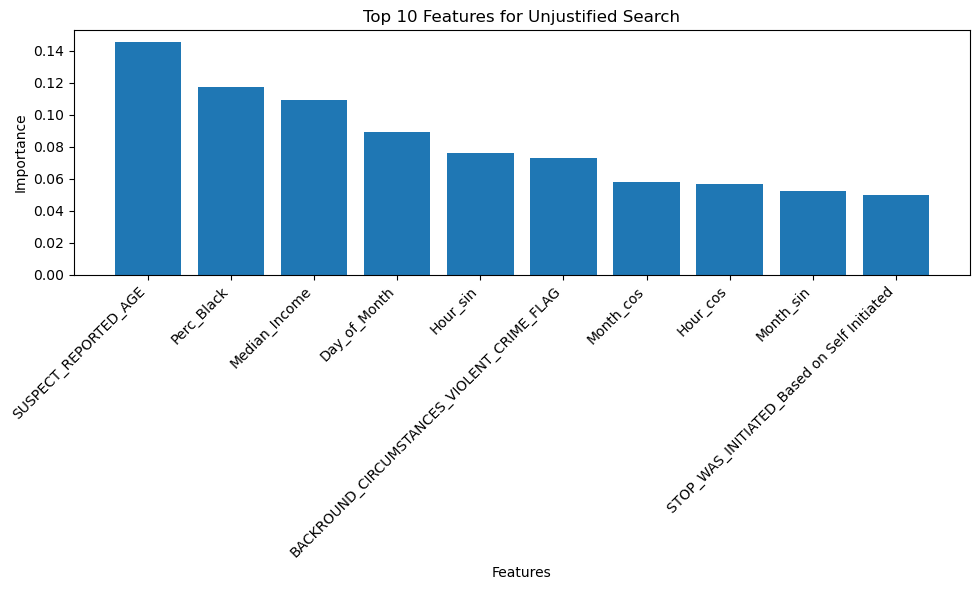

In [51]:
feature_importance = pd.DataFrame({
    'feature': selected_features_search,
    'importance': gb_search.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Features for Unjustified Search')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

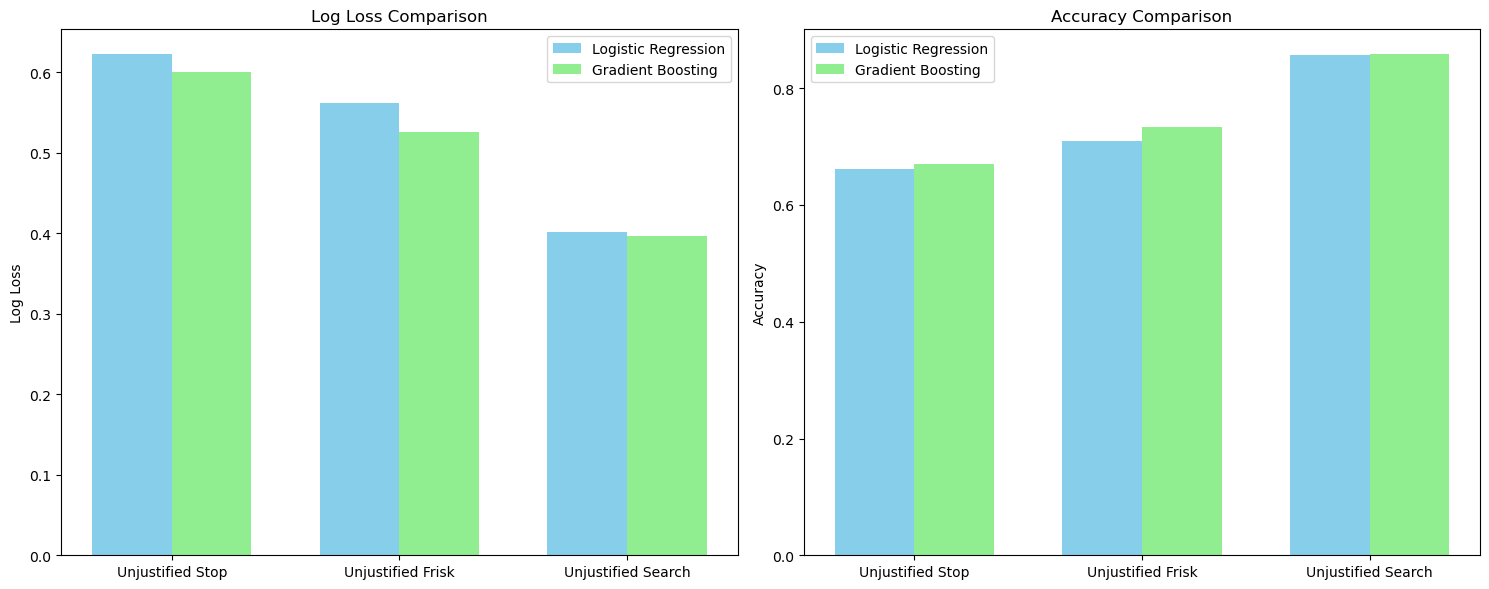

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

tasks = ['Unjustified Stop', 'Unjustified Frisk', 'Unjustified Search']
log_loss_lr = [0.622, 0.562, 0.402]
log_loss_gb = [0.600, 0.526, 0.396]
accuracy_lr = [0.661, 0.710, 0.857]
accuracy_gb = [0.670, 0.733, 0.858]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

x = range(len(tasks))
width = 0.35

ax1.bar([i - width/2 for i in x], log_loss_lr, width, label='Logistic Regression', color='skyblue')
ax1.bar([i + width/2 for i in x], log_loss_gb, width, label='Gradient Boosting', color='lightgreen')
ax1.set_ylabel('Log Loss')
ax1.set_title('Log Loss Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(tasks)
ax1.legend()

ax2.bar([i - width/2 for i in x], accuracy_lr, width, label='Logistic Regression', color='skyblue')
ax2.bar([i + width/2 for i in x], accuracy_gb, width, label='Gradient Boosting', color='lightgreen')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(tasks)
ax2.legend()

plt.tight_layout()
plt.show()

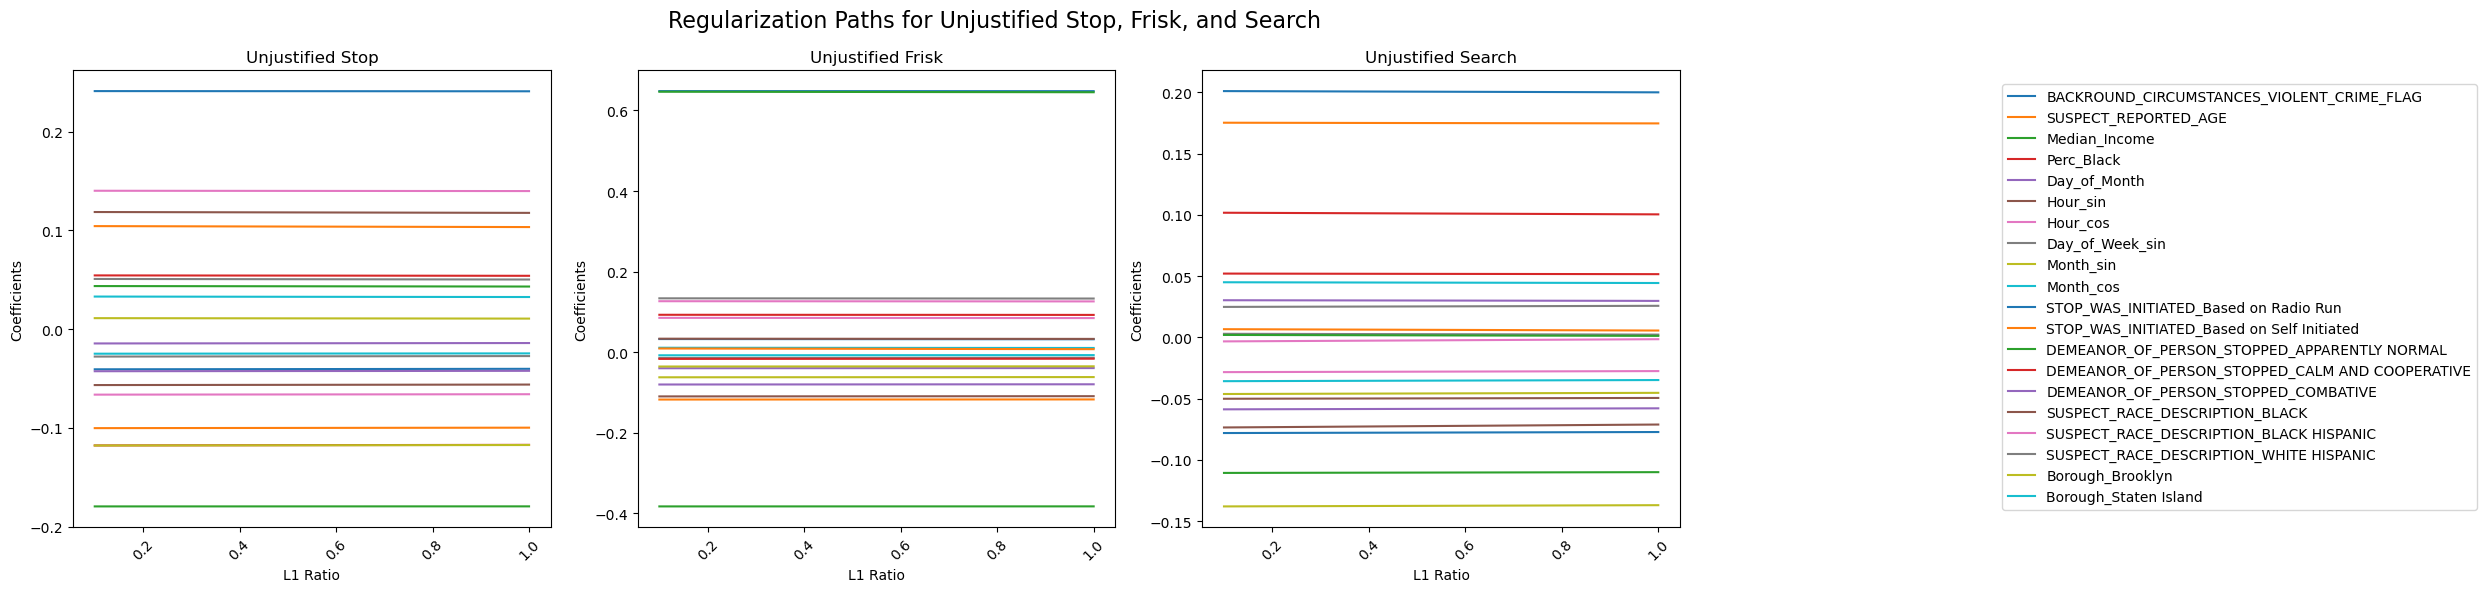

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

def plot_combined_regularization_path(X_list, y_list, feature_names_list, titles):
    l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Regularization Paths for Unjustified Stop, Frisk, and Search', fontsize=16)
    
    for idx, (X, y, feature_names, title) in enumerate(zip(X_list, y_list, feature_names_list, titles)):
        coefs = []
        for l1_ratio in l1_ratios:
            lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=l1_ratio, max_iter=1000)
            lr.fit(X, y)
            coefs.append(lr.coef_[0])
        
        coefs = np.array(coefs)
        
        ax = axes[idx]
        for i, name in enumerate(feature_names):
            ax.plot(l1_ratios, coefs[:, i], '-', label=name)
        
        ax.set_xlabel('L1 Ratio')
        ax.set_ylabel('Coefficients')
        ax.set_title(f'{title}')
        ax.tick_params(axis='x', rotation=45)
    
    # Create a single legend for all subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()

# Call the function with all three datasets
plot_combined_regularization_path(
    [X_train_gb_stop, X_train_gb_frisk, X_train_gb_search],
    [y_stop_train, y_frisk_train, y_search_train],
    [selected_features_stop, selected_features_frisk, selected_features_search],
    ['Unjustified Stop', 'Unjustified Frisk', 'Unjustified Search']
)

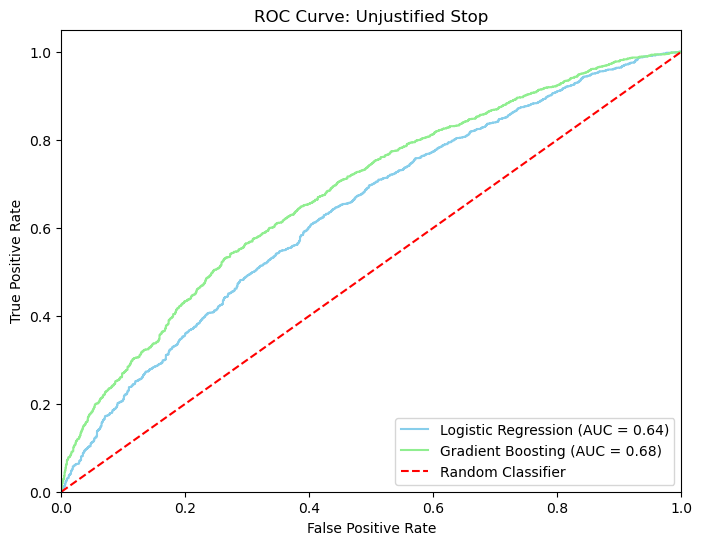

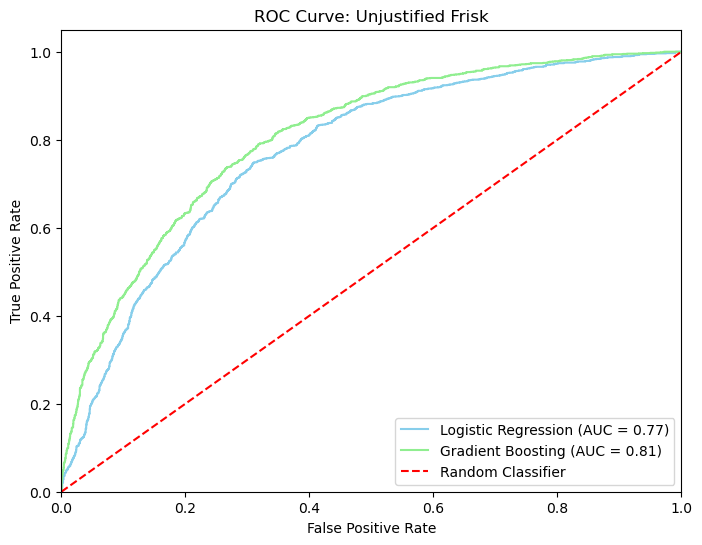

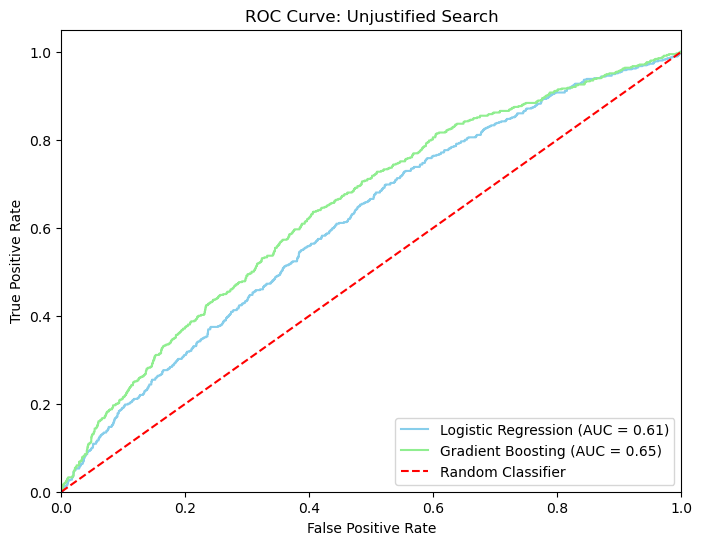

In [59]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, y_pred_lr, y_pred_gb, title):
    fpr_lr, tpr_lr, _ = roc_curve(y_true, y_pred_lr)
    fpr_gb, tpr_gb, _ = roc_curve(y_true, y_pred_gb)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    roc_auc_gb = auc(fpr_gb, tpr_gb)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_lr, tpr_lr, color='skyblue', label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
    plt.plot(fpr_gb, tpr_gb, color='lightgreen', label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {title}')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curves(y_stop_test, lr_stop.predict_proba(X_test_scaled)[:, 1], gb_stop.predict_proba(X_test_gb_stop)[:, 1], 'Unjustified Stop')
plot_roc_curves(y_frisk_test, lr_frisk.predict_proba(X_test_scaled)[:, 1], gb_frisk.predict_proba(X_test_gb_frisk)[:, 1], 'Unjustified Frisk')
plot_roc_curves(y_search_test, lr_search.predict_proba(X_test_scaled)[:, 1], gb_search.predict_proba(X_test_gb_search)[:, 1], 'Unjustified Search')

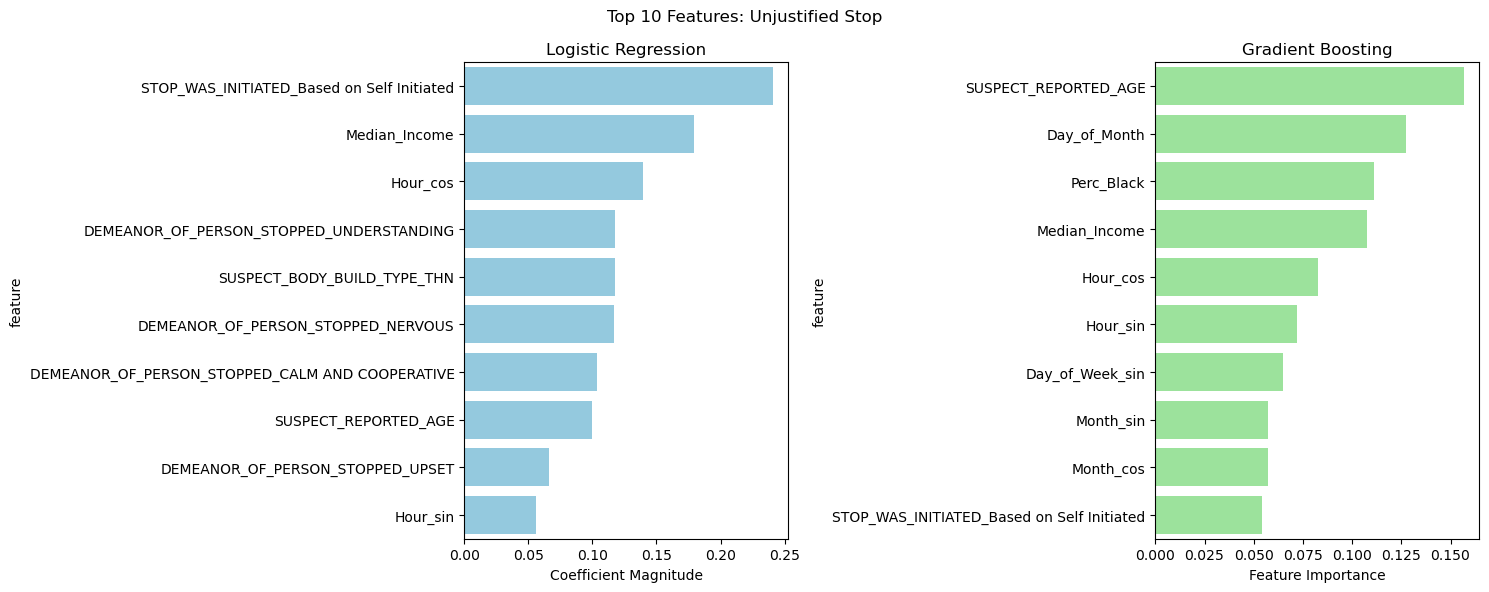

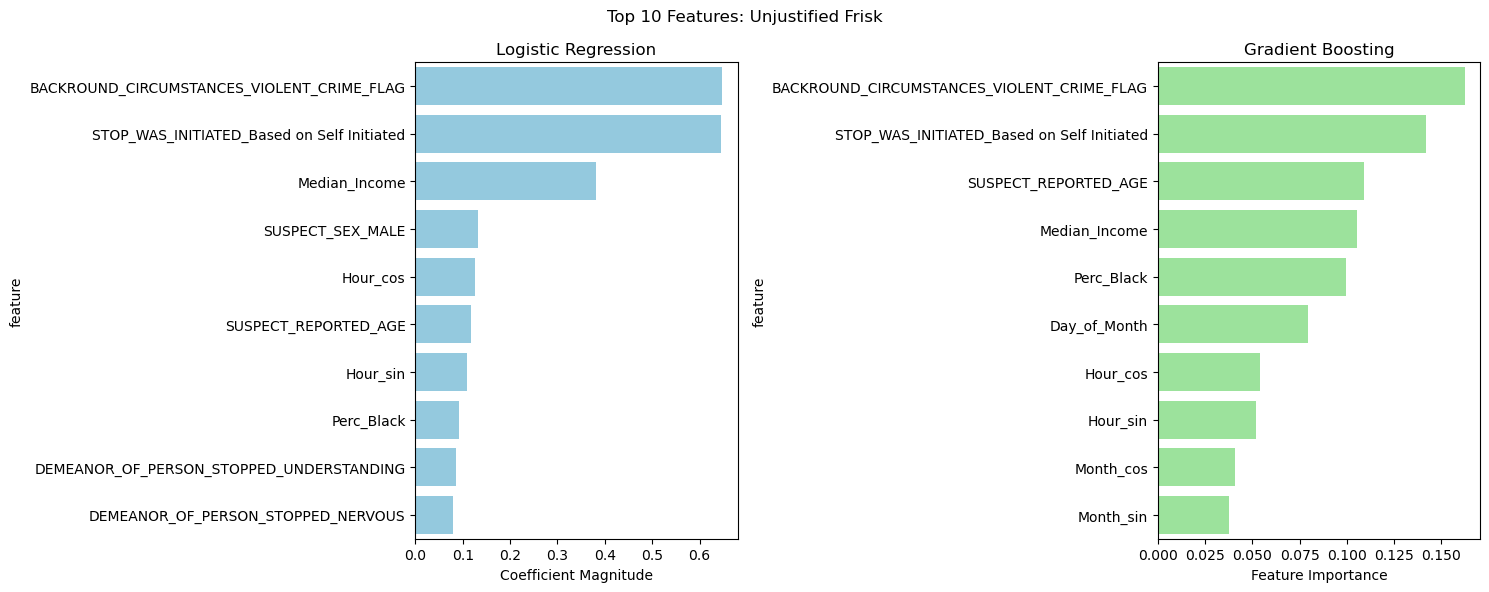

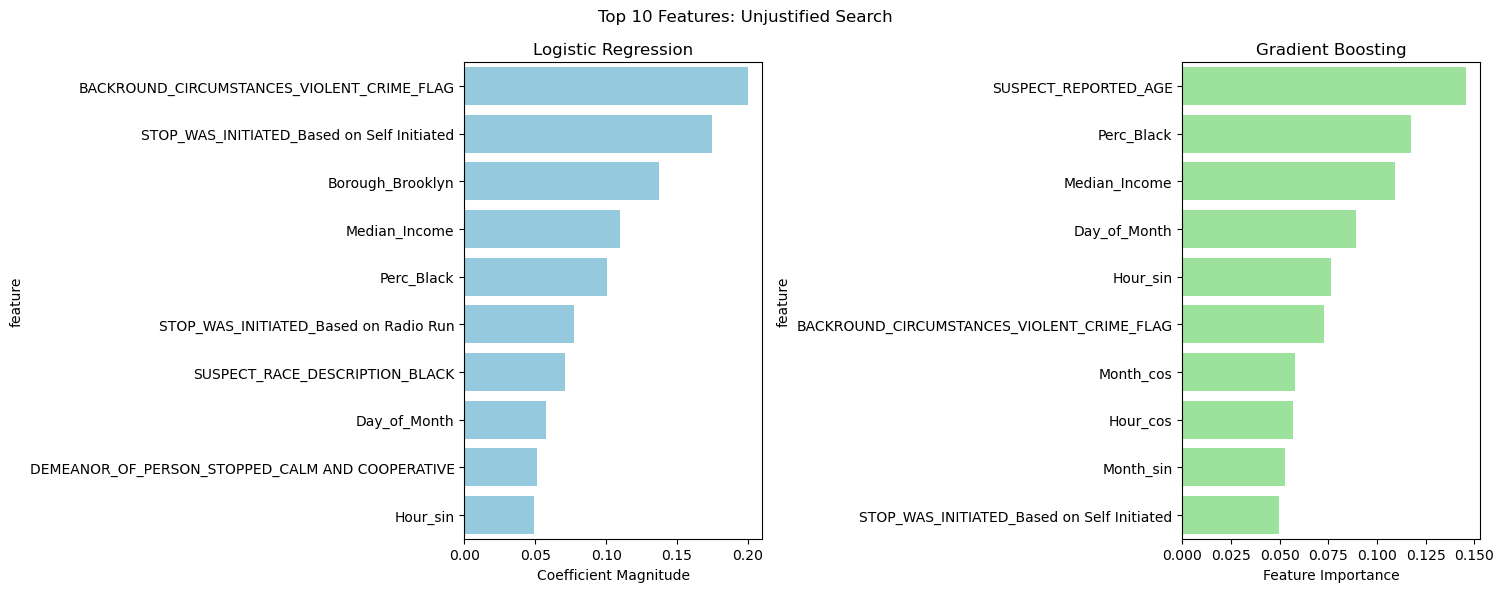

In [62]:
def plot_feature_importance_comparison(lr_model, gb_model, feature_names, title):
    lr_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(lr_model.coef_[0])
    }).sort_values('importance', ascending=False).head(10)
    
    gb_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': gb_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(x='importance', y='feature', data=lr_importance, ax=ax1, color='skyblue')
    ax1.set_title('Logistic Regression')
    ax1.set_xlabel('Coefficient Magnitude')
    
    sns.barplot(x='importance', y='feature', data=gb_importance, ax=ax2, color='lightgreen')
    ax2.set_title('Gradient Boosting')
    ax2.set_xlabel('Feature Importance')
    
    plt.suptitle(f'Top 10 Features: {title}')
    plt.tight_layout()
    plt.show()

# Retrain logistic regression models on the same features as gradient boosting
lr_stop = LogisticRegression(penalty='l1', solver='liblinear', random_state=2024)
lr_stop.fit(X_train_gb_stop, y_stop_train)

lr_frisk = LogisticRegression(penalty='l1', solver='liblinear', random_state=2024)
lr_frisk.fit(X_train_gb_frisk, y_frisk_train)

lr_search = LogisticRegression(penalty='l1', solver='liblinear', random_state=2024)
lr_search.fit(X_train_gb_search, y_search_train)

plot_feature_importance_comparison(lr_stop, gb_stop, selected_features_stop, 'Unjustified Stop')
plot_feature_importance_comparison(lr_frisk, gb_frisk, selected_features_frisk, 'Unjustified Frisk')
plot_feature_importance_comparison(lr_search, gb_search, selected_features_search, 'Unjustified Search')